<center> <h1> Assignment 1: Neural Networks and Supervised Learning </h1> </center>

<center> <h4> COMP 5600 Artificial Intelligence - Mallory Whitt </h4> </center>

### Part A: Forward Pass Simulation Function

Below, I implemented the specified forward pass function. The pass is called with input x = 5.0 and the later specified weights used. An example output is given.

In [6]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def relu(x):
    return max(0, x)

def forward_pass(x, weights):
    a_values = {}
    z_values = {}

    # node 1
    a_values[1] = x
    z_values[1] = sigmoid(a_values[1])

    # node 2
    a_values[2] = weights[1][2] * z_values[1]
    z_values[2] = relu(a_values[2])

    # node 3
    a_values[3] = weights[1][3] * z_values[1] + weights[2][3] * z_values[2]
    z_values[3] = sigmoid(a_values[3])

    # node 4
    a_values[4] = weights[1][4] * z_values[1] + weights[2][4] * z_values[2]
    z_values[4] = sigmoid(a_values[4])

    # node 5
    a_values[5] = weights[3][5] * z_values[3] + weights[4][5] * z_values[4]
    z_values[5] = a_values[5]

    return {'a': a_values, 'z': z_values}


weights = [
    [0,   0,   0,   0,   0,   0],
    [0,   0,   3,  -4,  -1,   0],
    [0,   0,   0,   1,  -3,   0],
    [0,   0,   0,   0,   0,   2],
    [0,   0,   0,   0,   0, -10],
    [0,   0,   0,   0,   0,   0]
]

result = forward_pass(5.0, weights)

print("Pre-activations:", result['a'])
print("Activations:", result['z'])

Pre-activations: {1: 5.0, 2: 2.979921447227146, 3: -0.993307149075715, 4: -9.933071490757154, 5: 0.5400332966834759}
Activations: {1: 0.9933071490757153, 2: 2.979921447227146, 3: 0.270259348906166, 4: 4.854011288561296e-05, 5: 0.5400332966834759}


### Part B: Backward Pass Simulation Function
I am including a separate pdf with my derivations for the output node and hidden node delta functions. Below, I implemented the specified backward pass function.

In [17]:
def sigmoid_grad_from_z(z):
    return z * (1 - z)

def relu_grad_from_a(a):
    return 1.0 if a > 0 else 0.0

def backward_pass(a_values, z_values, y_true, weights):
    deltas = {}

    # node 5
    deltas[5] = (z_values[5] - y_true) * 1.0

    # node 4
    down_4 = weights[4][5] * deltas[5]
    deltas[4] = sigmoid_grad_from_z(z_values[4]) * down_4

    # node 3
    down_3 = weights[3][5] * deltas[5]
    deltas[3] = sigmoid_grad_from_z(z_values[3]) * down_3

    # node 2
    down_2 = weights[2][3] * deltas[3] + weights[2][4] * deltas[4]
    deltas[2] = relu_grad_from_a(a_values[2]) * down_2

    # node 1
    down_1 = (weights[1][2] * deltas[2] +
              weights[1][3] * deltas[3] +
              weights[1][4] * deltas[4])
    deltas[1] = sigmoid_grad_from_z(z_values[1]) * down_1

    return deltas

def compute_grads(z_values, deltas):
    
    grads = [[0]*6 for _ in range(6)]
    
    grads[1][2] = z_values[1] * deltas[2]
    grads[1][3] = z_values[1] * deltas[3]
    grads[1][4] = z_values[1] * deltas[4]
    grads[2][3] = z_values[2] * deltas[3]
    grads[2][4] = z_values[2] * deltas[4]
    grads[3][5] = z_values[3] * deltas[5]
    grads[4][5] = z_values[4] * deltas[5]
    
    return grads

### Part C: Sample Calculations
The two samples (x = 0.0, y = 0.5 & x = 1.0, y = 0.1) are used in forwards and backwards calculations. Their respective activations and error signals are printed.

In [23]:
import builtins

def run_sample(x, y):
    out = forward_pass(x, weights)
    a, z = out['a'], out['z']
    d = backward_pass(a, z, y_true=y, weights=weights)
    return z, d

# Sample 1
z1, d1 = run_sample(0.0, 0.5)
# Sample 2
z2, d2 = run_sample(1.0, 0.1)

def r(x): 
    return builtins.round(float(x), 3)

print("Sample (x=0.0, y=0.5)")
for i in range(1,6):
    print(f"z{i}={r(z1[i])},  δ{i}={r(d1[i])}")

print("\nSample (x=1.0, y=0.1)")
for i in range(1,6):
    print(f"z{i}={r(z2[i])},  δ{i}={r(d2[i])}")


Sample (x=0.0, y=0.5)
z1=0.5,  δ1=0.009
z2=1.5,  δ2=0.126
z3=0.378,  δ3=0.088
z4=0.007,  δ4=-0.013
z5=0.688,  δ5=0.188

Sample (x=1.0, y=0.1)
z1=0.731,  δ1=-0.04
z2=2.193,  δ2=0.249
z3=0.325,  δ3=0.238
z4=0.001,  δ4=-0.004
z5=0.643,  δ5=0.543


### Part D: SGD Training Function
The SGD training function is implemented below. The final MSE is displayed after the specified samples, weights, learning rate, and epochs are passed as parameters to the function.

In [28]:
def mse_over_dataset(samples, weights):
    total = 0.0
    for x, y in samples:
        z5 = forward_pass(x, weights)['z'][5]
        total += 0.5 * (float(z5) - float(y))**2
    return total / len(samples)

def train_sgd(samples, weights, learning_rate, epochs):
    w = [row[:] for row in weights]
    history = []
    for epoch in range(epochs):
        for x, y in samples:
            out = forward_pass(x, w)
            a_vals, z_vals = out['a'], out['z']
            deltas = backward_pass(a_vals, z_vals, y, w)
            grads = compute_grads(z_vals, deltas)
            for i in range(len(w)):
                for j in range(len(w[i])):
                    w[i][j] -= learning_rate * grads[i][j]
        epoch_mse = mse_over_dataset(samples, w)
        history.append(epoch_mse)
    return w, history

samples = [(0.0, 0.5), (1.0, 0.1)]
trained, hist = train_sgd(samples, weights, 0.1, 20)

print("Trained weights:")
for i in range(1, 6):
    for j in range(1, 6):
        if trained[i][j] != 0:
            print(f"W{i}{j} = {r(trained[i][j])}")

print("Final MSE:", r(mse_over_dataset(samples, trained)))


Trained weights:
W12 = 2.896
W13 = -4.124
W14 = -1.0
W23 = 0.636
W24 = -2.999
W35 = 1.891
W45 = -10.0
Final MSE: 0.013


### Part E: Training Results
Below are the training results for the 11 given sample values. The evolution of error, predictions vs. true values, and final weights are displayed.

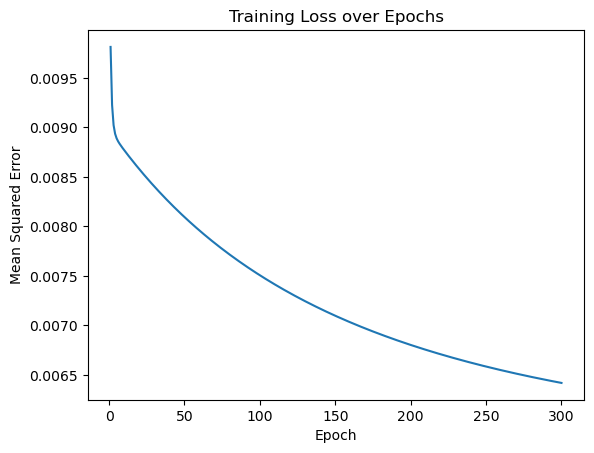

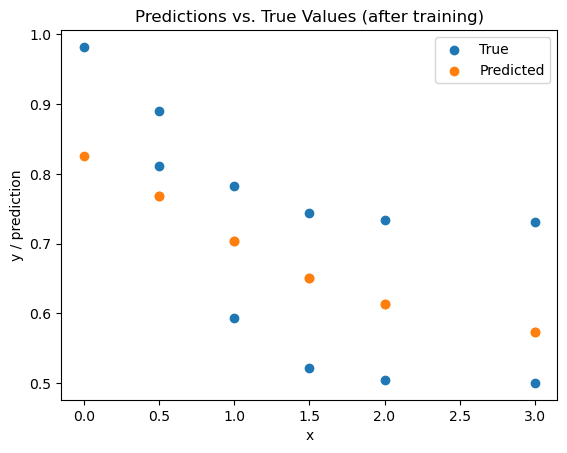

Final MSE: 0.0064179955119608775
Final weights:


AttributeError: 'list' object has no attribute 'keys'

In [30]:
import matplotlib.pyplot as plt

samples = [
    (3.0, 0.7312),
    (2.0, 0.7339),
    (1.5, 0.7438),
    (1.0, 0.7832),
    (0.5, 0.8903),
    (0.0, 0.9820),
    (0.5, 0.8114),
    (1.0, 0.5937),
    (1.5, 0.5219),
    (2.0, 0.5049),
    (3.0, 0.5002),
]

learning_rate = 0.05
epoch_num = 300

trained_w, loss_hist = train_sgd(samples, weights, learning_rate, epoch_num)

# Evolution of error
plt.figure()
plt.plot(range(1, len(loss_hist)+1), loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training Loss over Epochs")
plt.show()

# Predictions vs. true values
xs  = [x for x, _ in samples]
ys  = [y for _, y in samples]
yhat = [forward_pass(x, trained_w)['z'][5] for x in xs]

plt.figure()
plt.scatter(xs, ys, label="True")
plt.scatter(xs, yhat, label="Predicted")
plt.xlabel("x")
plt.ylabel("y / prediction")
plt.title("Predictions vs. True Values (after training)")
plt.legend()
plt.show()

# 6) Final weights and final MSE
print("Final MSE:", mse_over_dataset(samples, trained_w))
print("Final weights:")
for k in sorted(trained_w.keys()):
    print(f"  {k}: {trained_w[k]:.6f}")


## Disclosure of AI Tools

I mindfully used AI for this assignment. I double checked some of my work with the AI’s
input. I am trut

**By writing this reflection, I acknowledge that AI is a support tool, not a substitute for my
own effort, and I take full responsibility for the final submission.**